In [339]:
import pandas as pd
from operator import itemgetter
import ast

import matplotlib.pyplot as plt

import networkx as nx
import networkx.algorithms.community as nx_comm
import numpy as np

In [340]:
df = pd.read_csv("tweets-04-07.csv", index_col = [0])

In [341]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9916 entries, 0 to 9915
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   author_id            9916 non-null   int64  
 1   context_annotations  9916 non-null   object 
 2   created_at           9916 non-null   object 
 3   entities             9230 non-null   object 
 4   id                   9916 non-null   int64  
 5   in_reply_to_user_id  2347 non-null   float64
 6   text                 9916 non-null   object 
 7   name                 9914 non-null   object 
 8   username             9916 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 774.7+ KB


In [342]:
in_reply_to_user_df = df[df['in_reply_to_user_id'].notna()]

In [343]:
in_reply_to_user_df = in_reply_to_user_df.merge(df, left_on='in_reply_to_user_id', right_on='author_id')
in_reply_to_user_df = in_reply_to_user_df.rename(columns={"username_x": "target","username_y": "source", "context_annotations_x":"context_annotations"})
in_reply_to_user_df = in_reply_to_user_df[["source", "target", "context_annotations"]]
in_reply_to_user_df = in_reply_to_user_df.drop_duplicates(keep= 'first', ignore_index=True)

In [344]:
in_reply_to_user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   source               450 non-null    object
 1   target               450 non-null    object
 2   context_annotations  450 non-null    object
dtypes: object(3)
memory usage: 10.7+ KB


In [345]:
mentions = []
for i in range(len(df)):
  if isinstance((df["entities"][i]), str):
    if "mentions" in ast.literal_eval(df["entities"][i]).keys():
      mention = {
          "id": df["id"][i],
          "mention_username": ast.literal_eval(df["entities"][i]).get("mentions")[0].get("username")
        }
      mentions.append(mention)

mentions_df = pd.DataFrame(mentions)
mentions_df.head()

,id,mention_username
0,1543671325889380354,Azorukonn
1,1543671264694308864,ohmybeautybank
2,1543670132236464129,ohmybeautybank
3,1543671253512364036,ryosuketarou
4,1543671171064872960,ohmybeautybank


In [346]:
tweets_mention_df = mentions_df.merge(df, left_on='id', right_on='id')
tweets_mention_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7197 entries, 0 to 7196
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   7197 non-null   int64  
 1   mention_username     7197 non-null   object 
 2   author_id            7197 non-null   int64  
 3   context_annotations  7197 non-null   object 
 4   created_at           7197 non-null   object 
 5   entities             7197 non-null   object 
 6   in_reply_to_user_id  2143 non-null   float64
 7   text                 7197 non-null   object 
 8   name                 7197 non-null   object 
 9   username             7197 non-null   object 
dtypes: float64(1), int64(2), object(7)
memory usage: 618.5+ KB


In [347]:
user_mentions_df = tweets_mention_df.rename(columns={"username": "source", "mention_username": "target"})
user_mentions_df = user_mentions_df[["source", "target", "context_annotations"]]
user_mentions_df = user_mentions_df.drop_duplicates(keep= 'first', ignore_index=True)
user_mentions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6691 entries, 0 to 6690
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   source               6691 non-null   object
 1   target               6691 non-null   object
 2   context_annotations  6691 non-null   object
dtypes: object(3)
memory usage: 156.9+ KB


In [348]:
final_df = pd.concat([in_reply_to_user_df, user_mentions_df], ignore_index=True)
# final_df = final_df.drop_duplicates(keep= 'first', ignore_index=True)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7141 entries, 0 to 7140
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   source               7141 non-null   object
 1   target               7141 non-null   object
 2   context_annotations  7141 non-null   object
dtypes: object(3)
memory usage: 167.5+ KB


In [349]:
final_df.head()

,source,target,context_annotations
0,ohmybeautybank,timtempe,"[{'domain': {'id': '65', 'name': 'Interests an..."
1,ohmybeautybank,abyprtmaa,"[{'domain': {'id': '65', 'name': 'Interests an..."
2,ohmybeautybank,Polaris_0404,"[{'domain': {'id': '65', 'name': 'Interests an..."
3,ohmybeautybank,bubblegun__,"[{'domain': {'id': '65', 'name': 'Interests an..."
4,ohmybeautybank,clapclapcacaca1,"[{'domain': {'id': '65', 'name': 'Interests an..."


# Proses Segmentasi

In [350]:
G = nx.Graph()

In [351]:
G = nx.from_pandas_edgelist(final_df, 'source', 'target')

In [352]:
pos = nx.kamada_kawai_layout(G)

## Mengukur Topologi Jejaring Sosial Secara Keseluruhan

In [353]:
# Menampilkan Jumlah Nodes
print('Jumlah nodes', nx.number_of_nodes(G))

# Menampilkan Jumlah Edges
print('Jumlah edges', nx.number_of_edges(G))

# Menampilkan Density
print('Density', nx.density(G))

# Menapilkan Jumlah Connected Component
print('Jumlah connected component', nx.number_connected_components(G))

Jumlah nodes 7206
Jumlah edges 6541
Density 0.00025196829768084003
Jumlah connected component 1032


In [354]:
# Deteksi komunitas menggunakan modularity
communities = sorted(nx_comm.greedy_modularity_communities(G), key=len, reverse=True)
nx_comm.modularity(G, communities)

0.9166371370164232

In [355]:
modularity_dict = {} # Create a blank dictionary
for i,c in enumerate(communities): # Loop through the list of communities, keeping track of the number for the community
    for name in c: # Loop through each person in a community
        modularity_dict[name] = i # Create an entry in the dictionary for the person, where the value is which group they belong to.

# Now you can add modularity information like we did the other metrics
nx.set_node_attributes(G, modularity_dict, 'modularity')

# Visualisasi

In [356]:
# Membuat fungsi komunitas
def set_node_community(G, communities):
    "'Add community to node attributes'"
    for c, v_c in enumerate(communities):
        for v in v_c:
            # Add 1 to save 0 for external edges
            G.nodes[v]['community'] = c + 1

# Membuat fungsi warna
def get_color(i, r_off=1, g_off=1, b_off=1):
    "'Assign a color to an edge'"
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i+r_off)*3) % n)/(n-1)
    g=low+span*(((i+g_off)*5)%n)/(n-1)
    b=low+span*(((i+b_off)*7)%n)/(n-1)
    return(r,g,b)

# Menetapkan komunitas untuk setiap node
community = set_node_community(G, communities)

# Menetapkan warna node
node_color = [get_color(G.nodes[v]['community']) for v in G.nodes]

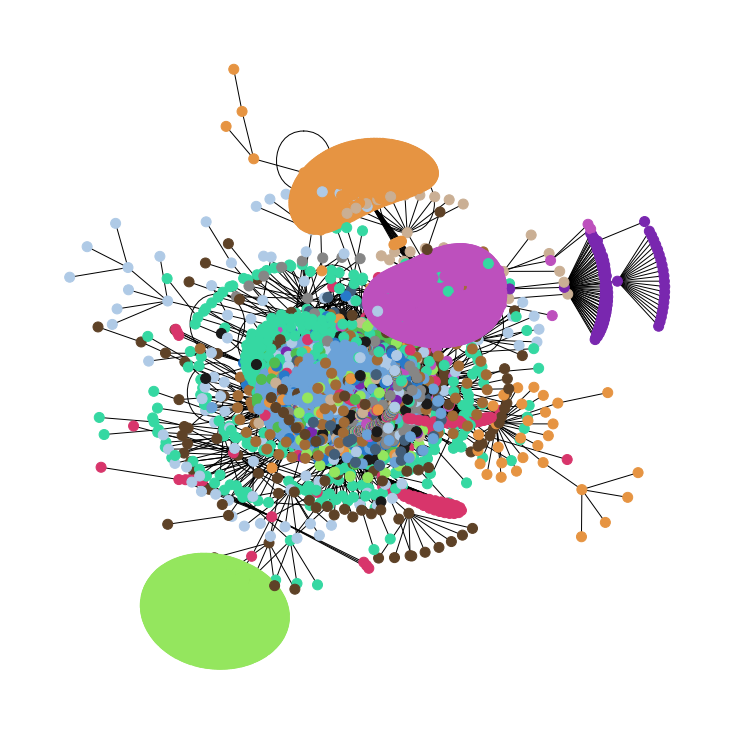

In [357]:
# Memvisualisasikan jaringan
plt.figure(figsize=(10,10))
nx.draw(G, with_labels=False,
        node_color=node_color,
        node_size=100,
        # arrowstyle='->', arrowsize=20, 
        # font_size=9,
        cmap=plt.get_cmap('jet'),
        pos=pos)

# for node, (x, y) in pos.items():
#     plt.text(x, y, node, fontsize=d[node]*70, ha='center', va='center', color="black")

In [358]:
context = {(j["source"],j["target"]):ast.literal_eval(j["context_annotations"]) for i, j in final_df.iterrows()}
nx.set_edge_attributes(G, context, "context")

In [359]:
filtered_dict = {k:v for (k,v) in modularity_dict.items() if v == 10}
(filtered_dict)

{'Alex753245': 10,
 'la_nomeolvides_': 10,
 'haniatwojastara': 10,
 'Irwinekxx': 10,
 '_Gohaa_': 10,
 'seaveand': 10,
 'adhd1312': 10,
 'AleksandraJakb1': 10,
 'mixersxoxo': 10,
 'stegozaury': 10,
 'EmiliaWr04': 10,
 'innocent_bae': 10,
 '_darkm00nlight_': 10,
 'tarasowa89': 10,
 'kaelipso': 10,
 'jeonbbyjk': 10,
 'cherry_tincture': 10,
 'mozetakmabyc': 10,
 'malinowawrozka': 10,
 'Piertucha_n': 10,
 'natiall_q': 10,
 '4iverse': 10,
 'Kasisia1': 10,
 'ttt_amelia': 10,
 'shittymood_': 10,
 'herbatka223': 10,
 'Martini79355885': 10,
 'unf6ckwitable': 10,
 'jadeclematis': 10,
 'jxjikanwbdf': 10,
 'xcabellosunx': 10,
 'klaus987': 10,
 'moonvith1': 10,
 'problematyczka_': 10,
 'Kroxiunia': 10,
 'Maleativ': 10,
 'Favvell': 10,
 'Kutaczan': 10,
 'odkochania': 10,
 'irytacjax': 10,
 'hovvleen': 10,
 'Blvkky': 10,
 'piwonia011': 10,
 'awh_Lukey_5': 10,
 'swietobliwosc': 10,
 'xz_kasia_zx': 10,
 'watermelonkkiwi': 10,
 'adorisysm': 10,
 'mniejnizero': 10,
 'jealousymon': 10,
 'Julia98773291': 10

In [360]:
def get_context(subgraph):
  subgraph_context = nx.get_edge_attributes(subgraph, "context")
  arr_context = []
  for i in list(subgraph_context.values()):
    for j in i:
      arr_context.append(j["entity"]["name"])
  res = {}

  for i in arr_context:
      res[i] = arr_context.count(i)
      
  return list(dict(sorted(res.items(), key=itemgetter(1),reverse=True)).keys())[:5]

['Travel', 'Destinations', 'Theme parks', 'Entertainment', 'Theme Park']


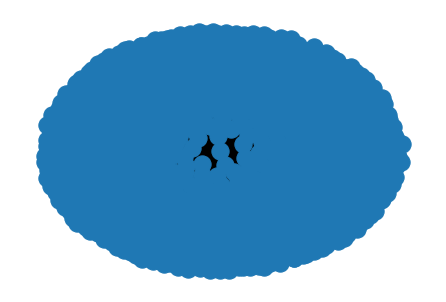

['Vogue Magazine', 'Fashion', 'Jin', 'Fashion Brand', 'K-pop']


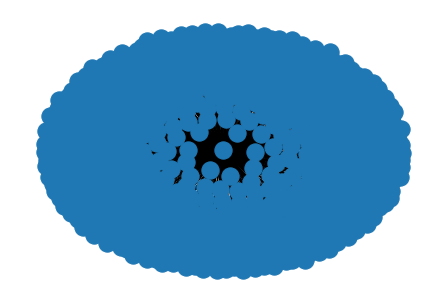

['Food', 'Food Blogs', 'Lunch', 'Cooking', 'Food experience']


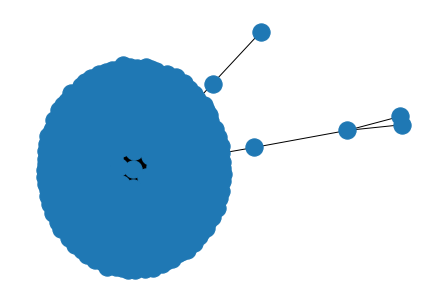

['Food', 'Food Blogs', 'Lunch', 'Indonesian cuisine', 'Fashion']


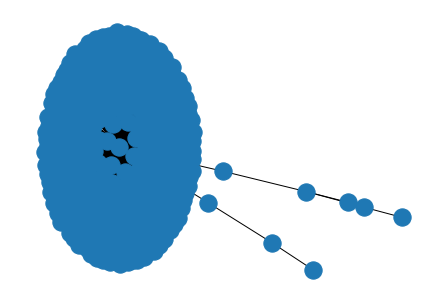

['ITZY', 'Yeji', 'Fashion', 'Fashion & beauty', 'Sneakers']


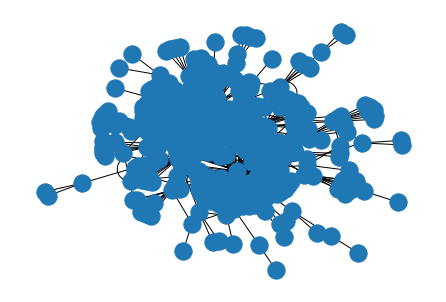

['Beauty', 'Fashion & beauty', 'Skin care', 'Makeup', 'Fashion']


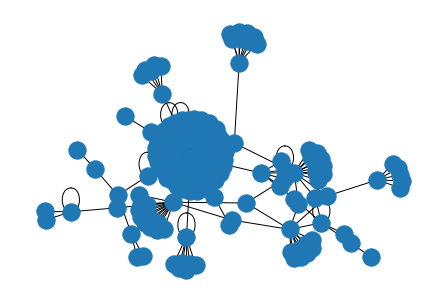

['Food', 'Indonesian cuisine', 'PlayStation', 'Entertainment', 'Services']


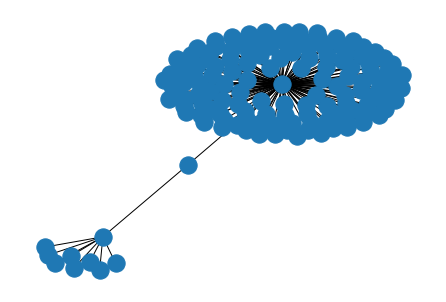

['Fashion', 'Handbags', 'Fashion & beauty', 'General Fashion', 'Fashion accessories']


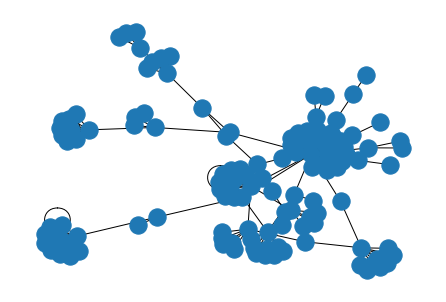

['Food', 'Indonesian cuisine', 'Fashion', 'Fashion & beauty', 'Sneakers']


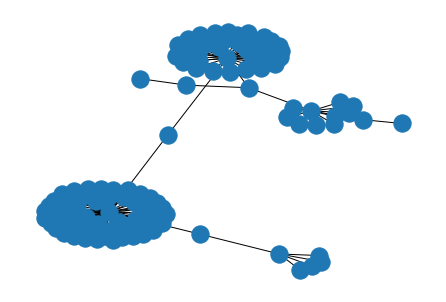

['Skin care', 'Fashion & beauty', 'Beauty', 'Fashion', 'Handbags']


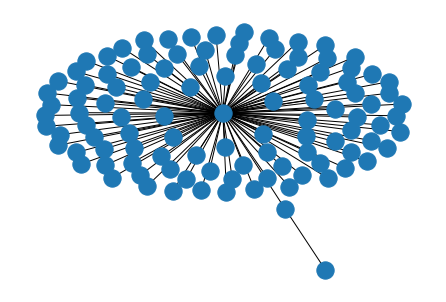

In [362]:
for i in range(10):
  # plt.figure(figsize=(10,10))
  subgraph = G.subgraph(communities[i])
  print(get_context(subgraph))
  nx.draw(subgraph, with_labels=False)
  plt.show()